# VC Dimension, Halfspaces, and the Polynomial Kernel

The perceptron hypothesis class is often called the hypothesis class of "half spaces" because it divides the space $R^d$ in half with a hyperplane.
In this assignment, you will create various synthetic datasets, and explore how changing the hyperparameters of the halfspace hypothesis class with the polynomial kernel affects the statistical performance.
The advantage of using synthetic data is that you can control various aspects of the data generation process to see how different sources of error result in different types of output.

The main purpose of this assignment is to help give you intuition for all of the terms and formulas we've been defining in lecture.

In [3]:
'''
This cell contains imports and global configurations.
You shouldn't have to modify anything in this cell.
'''

# import standard python libraries libraries
import math
import numpy as np
np.random.seed(0)
import random
random.seed(0)
import time

# disable warnings
from warnings import filterwarnings
filterwarnings('ignore')
import os
os.environ["PYTHONWARNINGS"] = "ignore"

# import data mining libraries
import sklearn.linear_model

# import and configure plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 1
#plt.rcParams['figure.figsize'] = [9, 6]
#plt.rcParams['figure.dpi'] = 150

# configurations for my code
default_num_trials = 25
max_d = 2**14

## Part 1: Exploring the VC Dimension of the polynomial kernel

In [14]:
def polynomial_kernel_embedding(x, p):
    '''
    Embeds the vector x into a higher dimensional space using the polynomial kernel of degree p.
    The output dimension is equal to the VC-dimension of Theta(min{p**d,d**p}), where d is the dimension of x.
    This is not an efficient implementation; it is designed for clarity.
    
    >>> polynomial_kernel_embedding(np.array([2]),1)
    array([2])
    >>> polynomial_kernel_embedding(np.array([2]),2)
    array([2, 4])
    >>> polynomial_kernel_embedding(np.array([2]),3)
    array([2, 4, 8])
    
    >>> polynomial_kernel_embedding(np.array([2,3]),1)
    array([2, 3])
    >>> polynomial_kernel_embedding(np.array([2,3]),2)
    array([2, 3, 4, 6, 9])
    >>> polynomial_kernel_embedding(np.array([2,3]),3)
    array([ 2,  3,  4,  6,  9,  8, 12, 18, 27])
    
    >>> polynomial_kernel_embedding(np.array(range(2)),10).shape
    (65,)
    >>> polynomial_kernel_embedding(np.array(range(3)),10).shape
    (285,)
    >>> polynomial_kernel_embedding(np.array(range(4)),10).shape
    (1000,)
    '''
    assert type(x) is np.ndarray
    assert len(x.shape) == 1
    assert type(p) is int
    assert p > 0
    
    d = x.shape[0]
    terms_per_degree = [ [ [i] for i in range(d) ] ]
    for i in range(1,p):
        deg_i_terms = []
        deg_i_minus1_terms = terms_per_degree[-1]
        for k in range(len(deg_i_minus1_terms)):
            for j in range(deg_i_minus1_terms[k][-1],d):
                deg_i_terms.append(deg_i_minus1_terms[k]+[j])
        terms_per_degree.append(deg_i_terms)
    
    terms = [ inner for outer in terms_per_degree for inner in outer ]
    
    values = []
    for term in terms:
        value = 1
        for i in term:
            value *= x[i]
        values.append(value)
    return np.array(values)
    
    embeddings = [x]
    for i in range(1,p):
        deg_i_terms = []
        deg_i_minus1_terms = embeddings[-1]
        for j in range(x.shape[0]):
            for k in range(deg_i_minus1_terms.shape[0]):
                deg_i_terms.append(x[j]*deg_i_minus1_terms[k])
        embeddings.append(np.array(deg_i_terms))
    return np.concatenate(embeddings)

import doctest
doctest.testmod()

TestResults(failed=0, attempted=9)

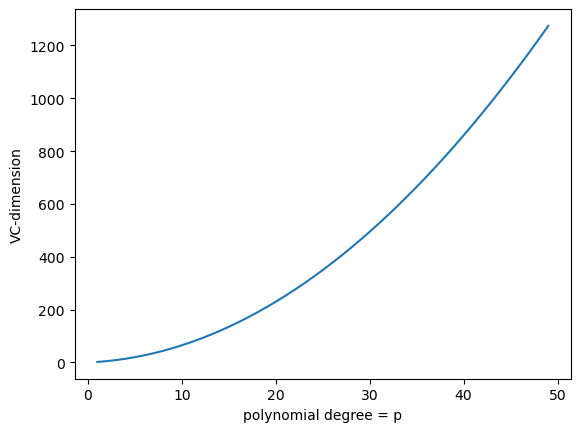

In [15]:
'''
This cell plots the VC-dimension of a halfspace with the polynomial kernel
as a function of the degree p with a fixed dimension d
'''
ps = range(1,50)
d = 2
vcdims = [ polynomial_kernel_embedding(np.ones([d]),p).shape for p in ps ]

fig, ax = plt.subplots()
plt.ylabel('VC-dimension')
plt.xlabel('polynomial degree = p')
plt.plot(ps,vcdims)
plt.show()

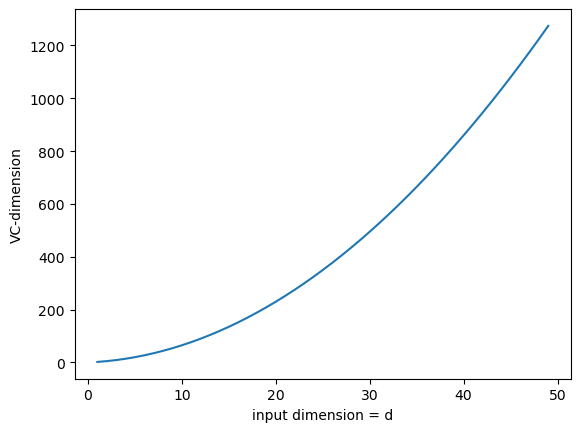

In [16]:
'''
This cell plots the VC-dimension of a halfspace with the polynomial kernel
as a function of the dimension d with a fixed p
'''
ds = range(1,50)
p = 2
vcdims = [ polynomial_kernel_embedding(np.ones([d]),p).shape for d in ds ]

fig, ax = plt.subplots()
plt.ylabel('VC-dimension')
plt.xlabel('input dimension = d')
plt.plot(ps,vcdims)
plt.show()

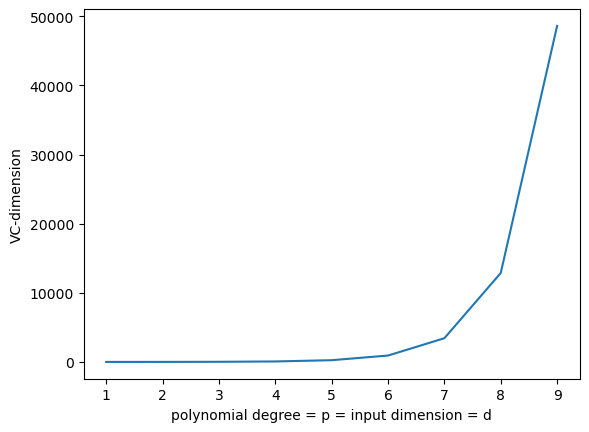

In [17]:
'''
This cell plots the VC-dimension of a halfspace with the polynomial kernel
as the dimension and degree both increase
'''
dps = range(1,10)
vcdims = [ polynomial_kernel_embedding(np.ones([dp]),dp).shape for dp in dps ]

fig, ax = plt.subplots()
plt.ylabel('VC-dimension')
plt.xlabel('polynomial degree = p = input dimension = d')
plt.plot(dps,vcdims)
plt.show()

### Question 1.1
*The plots above visualize the VC-dimension of halfspaces with the polynomical kernel.
In particular, they show regimes where the VC-dimension grows polynomially and regimes where it grows exponentially.*

*What is the formula for the VC-dimension of halfspaces with the polynomial kernel?*

Type your answers below each question in non-italic text.

Let $p$ be the polynomial degree and let $d$ be the input dimension. Then the vc dimension of the new space will be $\tilde{d}=$ ${p+d}\choose{p}$ but since we now get the vc dimension of halfspaces in this larger dimension the vc dimension of halfspaces after degree $p$ polynomial kernel on original data of ambient dimension $d$ will be $\tilde{d}+1 =$ ${p+d}\choose{p}$ $+1=\frac{(p+d)!}{p!d!}+1=O(p^d)$

### Question 1.2
*In most practical problems, the dimension $d$ of the input dataspace $\mathcal X$ is large ( think $d > 10^{6}$).
Large degree polynomial kernels ($p>3$) are not typically used in this situation.
Explain the downsides of using a large degree polynomial kernel in terms of sample complexity using VC theory.*

Increasing the degree p of a polynomial kernel significantly raises the VC dimension because it maps the input space to a much higher-dimensional feature space, with the VC dimension approximately growing as $O(p^d)$. According to VC theory, a higher VC dimension increases the sample complexity needed to achieve low generalization error, leading to looser bounds on the guarantees of generalization. If the VC dimension is too high and there are insufficient training samples, the model may overfit, capturing noise in the data and thus generalizing poorly to unseen data. So we will need a lot more samples to get same generalization error. So while we may reduce $E_{in}$ due to better flexibility our geneeralization will get poorer.

## Part 2: generating synthetic data with different properties

In [37]:
'''
This cell contains a number of functions for generating and visualizing datasets.
'''

def generate_dataset(m, d, f, sigma, seed=0):
    '''
    Returns a dataset with m data points of dimension d generated by:
    
        X ~ Uniform(-1, 1)
        Y = f(X) + epsilon, where epsilon ~ Normal(0,sigma)
        
    When sigma=0, there is no randomness in Y, and so the bayes error will be 0
    When sigma>0, there is randomness in Y, and so the bayes error > 0
    '''
    # set numpy's seed for reproducable results
    random.seed(seed)
    np.random.seed(seed)
    
    # ensure reasonable input parameters
    assert type(m) is int
    assert m>0
    
    # a helper function for generating labels
    def sign(a):
        if a>0:
            return 1
        else:
            return -1

    # generate the features
    X = np.random.uniform(low=-1.0,high=1.0,size=[m,d])

    # generate the labels
    Ys = []
    for i in range(m):
        epsilon = np.random.randn()*sigma
        yi = sign(f(X[i]) + epsilon)
        Ys.append(yi)
    Y = np.array(Ys)
    
    # return the dataset
    return (X,Y)


def f_polynomial(p, seed=0):
    '''
    Implements a polynomial embedding of degree $p$ to perform the data labeling.
    If the halfspace hypothesis class with the polynomial kernel of degree > p is used for learning,
    then the hypothesis class will be realizable.
    The input dimension $d$ must match the dimension of the dataspace $\mathcal X$
    '''
    phi = lambda x: polynomial_kernel_embedding(x, p)
    embedding_dim = phi(np.ones([d])).shape[0]
    np.random.seed(seed)
    #w = (np.array(range(embedding_dim))/embedding_dim)**0.01
    #w = np.ones([embedding_dim])/embedding_dim
    w = np.random.randn(max_d)/math.sqrt(embedding_dim)
    def f(x):
        phi_x = phi(x)
        w2 = w[:phi_x.shape[0]]
        return phi_x.transpose() @ w2
    return f
    
    
def f_checkers():
    '''
    This is another embedding function that creates a "checkers" pattern in the data.
    This embedding is not realizable for halfspaces with the polynomial kernel. 
    '''
    p = 4
    def f(x):
        return math.sin(x[0]*p)*math.sin(x[1]*p)
    return f

    
def f_circles():
    '''
    This is another embedding function that creates a pattern of concentric circles in the data.
    This embedding is not realizable for halfspaces with the polynomial kernel. 
    '''
    p = 4
    def f(x):
        return math.cos((x[0]*x[0]+x[1]*x[1])*p)
    return f
    

def plot_dataset(S):
    '''
    Plots the first two dimensions of the input dataset.
    '''
    X,Y = S
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],c=Y)
    #ax.scatter(X_pos[:,0], X_pos[:,1])
    #ax.scatter(X_neg[:,0], X_neg[:,1])
    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(-1.0,1.0)
    plt.tight_layout()
    plt.show()

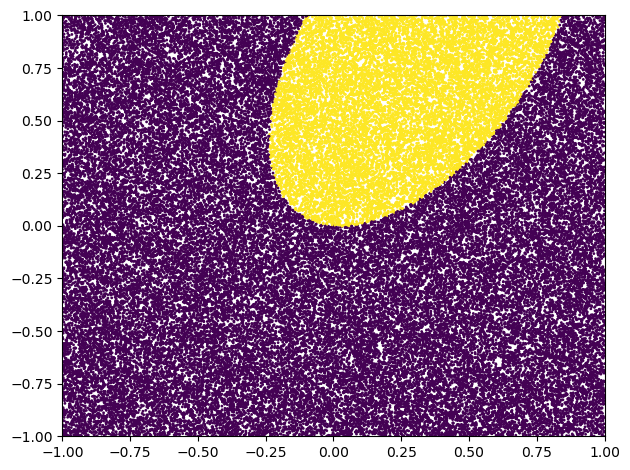

In [72]:
'''
This cell plots a dataset that has no randomness in the generation of class labels (sigma=0).
Using our notation from the textbook, this means that for each i, y_i = f(x_i).
When p=1 in the f_polynomial function, the data has a linear decision boundary.
'''

# these "hyperparameters" control the properties of the dataset
d = 2
sigma = 0
f = f_polynomial(p=2,seed=4)

# generate and plot dataset
S = generate_dataset(m=2**16,d=d,f=f,sigma=sigma)
plot_dataset(S)

### Question 2.1

*Regenerate the dataset above several times with degree $1 \le p \le 10$ to explore what decision boundaries for higher degree polynomials look like.
You should also change the `seed` value to generate different datasets with the same degree.*

*Write a 1-2 sentence summary of your findings.*

When p=1 the data generated seems to have a linear decision boundary ie a straight line. This makes sense as the f polynomial function the generates a polynomial function of degree p so a line is generated. When p=2 we get different quadratic/ conic inspired boundaries such as circles, ellipses, and quadratic curves that seem to be created by a function that uses degree 2 relationships between inputs so a degree 2 curve may seperate the data. Similiarlly as we increae p from 3, 4,..., 10 we say various more curves as polynomials of larger degree seem to create the underlying decision boundary upon which the data is based resulting in curvier and more interesting shapes that only seem to be higher degree relations with the input data. The seed is simply used to control randomness and ensure that we get the same output with same input for a particular seed so to see all the interesting shapes I found it important to vary the seed to see the various forms of shapes that could be realised for the decision boundary. For eg. in my computer seed=2 and p=2 results in a circle, while seed =4 p=2 results in a elliptical boundary (although incomplete ellipse due to axis chosen to be displayed). Hence changing seed shows the various possible shapes that may randomly occur.

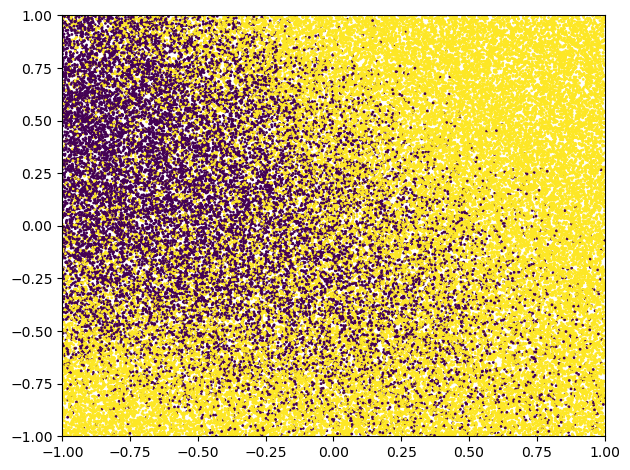

In [79]:
'''
This cell plots a dataset with randomness (sigma>0).
The sigma variable controls the amount of randomness applied to the model's label. 
'''

# these "hyperparameters" control the properties of the dataset
d = 2
sigma = 0.5
f = f_polynomial(2)

# generate and plot dataset
S = generate_dataset(m=2**16,d=d,f=f,sigma=sigma)
plot_dataset(S)

### Question 2.2

*Experiment with different combinations of sigma (and different p values) to see how the level of randomness effects the data.*

*Write a 1-2 sentence summary of your findings.*



increasing the value of sigma contributes to a larger error in the data and hence a larger bayes risk or true error of the data as the data now stops having a degree p decision boundary and now more and more anomalous data starts to pop up. This leads to the data appearing more "blurry" as with a larger sigma there is no exact curve that seperates the data into different regions. There seems to be more noise in the data with purple and yellow points being more dispersed and appearing deep in each other's regions. Increasing sigma leads to further noisy data and data of different form appearing even further into the region. We see that there is lots of noise near the decision boundary buut as we go further away noise reduces but if we increase sigma there seems to be noisy data even far into each side of the decision boundary.

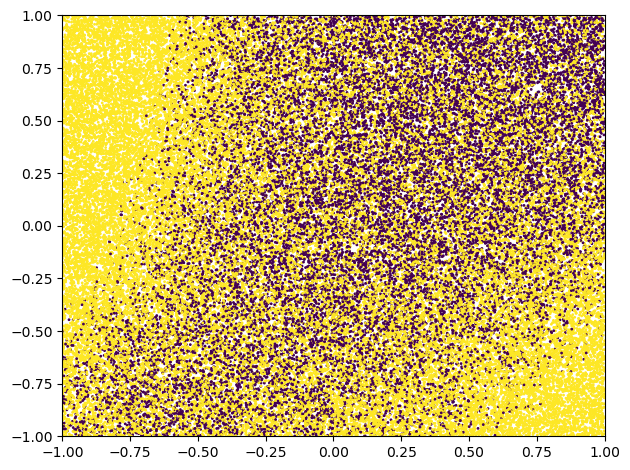

In [92]:
'''
This cell plots a dataset in the PAC model in higher dimensions.
Notice that even though there is no randomness in the labels,
there appears to be randomness when we only visualize the data in 2 dimensions.
'''

# these "hyperparameters" control the properties of the dataset
d = 3
sigma = 0
f = f_polynomial(3,seed=2)

# generate and plot dataset
S = generate_dataset(m=2**16,d=d,f=f,sigma=sigma)
plot_dataset(S)    

### Question 2.3

*Experiment with different values of `d` in the dataset plotted above.
Also experiment with different values of `p` and `sigma`.
Notice that in high dimensions it is very difficult to tell if the data is linearly separable, or if the data contains any randomness.
Write 1-2 sentences explaining why this is the case.*

The value d controls the dimension of the ambient space of our data, p controls the dimension of function that classifies our data and is the degree of the true labelling fucntion, and sigma is a measure of how much noise we want our data to have. When d is large for eg when d=3 and p=2 we may need a hyperplane to seperate our data which once we express in 2 dimesnsions like our computer does by emebedding data back to 2 dimensions this results in data that may need hyper planes to be seperable in higher dimensional spaces to not look seperable once we embed it down to 2 dimensional space on our computer screen. This was seen in the youtube video of the svm classifier we saw in class when linearly seperable data in 3 space failed to look linearly seperable in 2 space. Similiarly for eg. circles are not linearly seperale in 2 space but we do a ffeature transform to a larger space we can a linear seperator for it and then embed it back to our original space so it is very hard to tell if data is linearly seperable or has a bunch of randomness as to human brains we cannot visualize super high dimensional data.

## Part 3: plotting the error as a function of the sample size $m$

NOTE: The textbook uses the variable $N$ to measure the total number of data points, but this notebook uses the variable $m$ to denote the number of data points.

In [93]:
def calculate_err_vs_m(d, sigma, f, p, num_trials=default_num_trials):
    '''
    Plots the sample/true/generalization error for the halfspace with polynomial kernel model
    as a function of the number of sample training points.
    '''

    max_m_exp = 16
    m_buffer = 3
    
    # S_test is our test set used for measuring the model's performance;
    # It has a very large size to ensure that the empirical risk on S_test is very close to the true risk
    print('generating dataset... ',end='')
    S_test = generate_dataset(m=2**(max_m_exp+m_buffer),d=d,f=f,sigma=sigma)
    print('done')
    plot_dataset(S_test)

    # these lists store the computer training and test errors
    test_errs = []
    train_errs = []
    
    # This is the list of all sample sizes we will train models on and generate train/test errors;
    # by adjusting the range(), you can adjust the x-axis in the plots below.
    ms = [ 2**i for i in range(0,max_m_exp) ]

    for m in ms:
    #for p in [1,2,3,4,5,6,7]:

        # In order to "smooth" the plots, we will repeat each experiment multiple times
        # as deterimed by the num_trials parameter.
        # These lists store the raw results from each trial.
        trials_test_accs = []
        trials_train_accs = []
        
        # loop over each trial
        seed_base = 10
        time_start = time.time()
        for seed in range(seed_base,seed_base+num_trials):
            
            # generate a training set of size m
            # from the same distribution as our test set;
            # notice that we must explicitly set a unique seed for each trial so that
            # each iteration is actually running on a different training set
            S_train = generate_dataset(m=m,d=d,f=f,sigma=sigma,seed=seed)

            try:   
                # train a linear model;
                # notice that all of these models use the same hypothesis set of half spaces;
                # they only difference is that a different algorithm is used to select the hypothesis from the hypothesis class;
                # VC theory doesn't care about the training algorithm used to select the hypothesis from the class,
                # and so provides the same generalization bounds for all of these algorithms;
                # in practice, they all perform essentially the same statistically,
                # but they have different runtime characteristics in different situations
                X, Y = S_train
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                #h_S = sklearn.linear_model.LogisticRegression(solver='liblinear',C=1e10)
                #h_S = sklearn.linear_model.Perceptron()
                h_S = sklearn.linear_model.SGDClassifier(penalty=None)
                #h_S = sklearn.linear_model.PassiveAggressiveClassifier()
                #h_S = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
                #h_S = sklearn.svm.LinearSVC()
                h_S.fit(X, Y)

                # calculate the training accuracy
                train_acc = h_S.score(X,Y)

                # calculate the test accuracy
                X, Y = S_test
                X = X[:min(2048,m_buffer*m)]
                Y = Y[:min(2048,m_buffer*m)]
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                test_acc = h_S.score(X, Y)        

            # ValueError raised when there's not enough data to perform classification;
            # in this case, we get perfect training accuracy, but perfectly wrong test accuracy
            except ValueError:
                train_acc = 1
                test_acc = 0
                
            trials_test_accs.append(test_acc)
            trials_train_accs.append(train_acc)
        time_end = time.time()
        
        # compute the average of our trials
        train_acc = np.mean(trials_train_accs)
        test_acc = np.mean(trials_test_accs)
            
        # print a debugging statement for each iteration
        print('m=%8d,  train_acc=%0.4f,  test_acc=%0.4f,  time_diff=%dsec'%(
            m,
            train_acc,
            test_acc,
            time_end-time_start
        ))

        # convert the accuracies into errors and store them
        train_errs.append(1-train_acc)
        test_errs.append(1-test_acc)
    
    # plot the errors
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
    ax1.set_xscale('log',base=2)
    #ax1.set_yscale('log')
    ax1.set_ylim([0.0,1.0])
    ax1.set(
        xlabel='number of samples = m', 
        ylabel='train error = E_in(g)',
    )
    ax1.plot(ms,train_errs)
    
    ax2.set_xscale('log',base=2)
    #ax2.set_yscale('log')
    ax2.set_ylim([0.0,1.0])
    ax2.set(
        xlabel='number of samples = m', 
        ylabel='test error ≈ E_out(g)',
    )
    ax2.plot(ms,test_errs)
    
    ax3.set_xscale('log',base=2)
    ax3.set_yscale('log')
    ax3.set(
        xlabel='number of samples = m', 
        ylabel='generalization error = |E_in(g) - E_out(g)|',

    )
    ax3.plot(ms,np.abs(np.array(test_errs)-np.array(train_errs)))
    
    plt.tight_layout()
    plt.show()


generating dataset... done


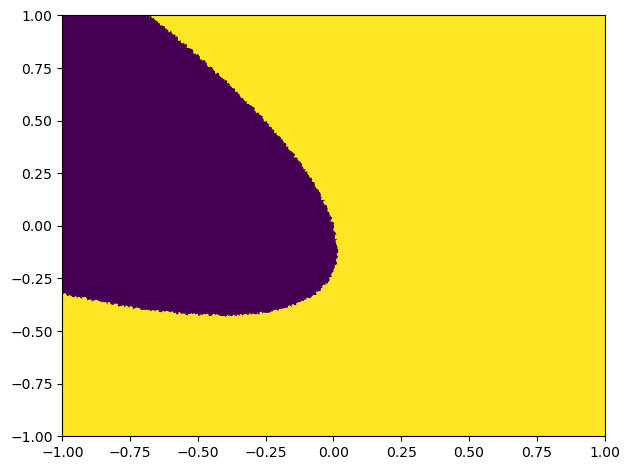

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.2400,  time_diff=0sec
m=       4,  train_acc=0.9900,  test_acc=0.4800,  time_diff=0sec
m=       8,  train_acc=0.9250,  test_acc=0.7083,  time_diff=0sec
m=      16,  train_acc=0.8775,  test_acc=0.8058,  time_diff=0sec
m=      32,  train_acc=0.8538,  test_acc=0.8325,  time_diff=0sec
m=      64,  train_acc=0.8313,  test_acc=0.8325,  time_diff=0sec
m=     128,  train_acc=0.8237,  test_acc=0.8068,  time_diff=0sec
m=     256,  train_acc=0.8144,  test_acc=0.8040,  time_diff=0sec
m=     512,  train_acc=0.8210,  test_acc=0.8224,  time_diff=0sec
m=    1024,  train_acc=0.8335,  test_acc=0.8272,  time_diff=0sec
m=    2048,  train_acc=0.8340,  test_acc=0.8298,  time_diff=0sec
m=    4096,  train_acc=0.8348,  test_acc=0.8300,  time_diff=0sec
m=    8192,  train_acc=0.8357,  test_acc=0.8315,  time_diff=1sec
m=   16384,  train_acc=0.8374,  test_acc=0.8327,  time_diff=3sec
m=   32768,  train_acc=0.

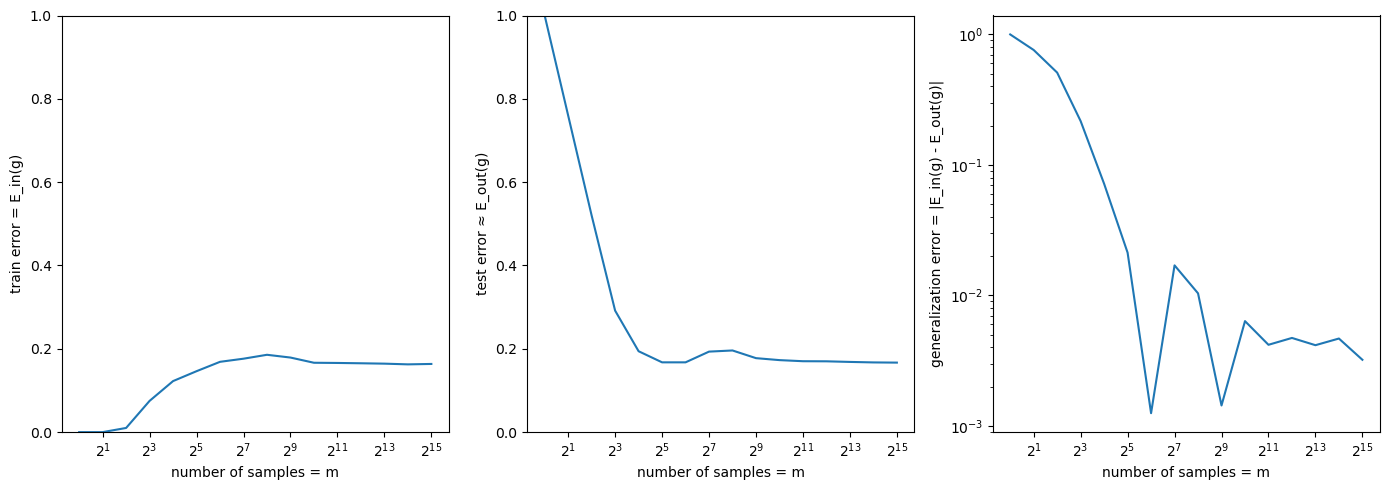

In [94]:
calculate_err_vs_m(
    d=2,
    sigma=0,
    f=f_polynomial(p=2),
    p=1,
)

generating dataset... done


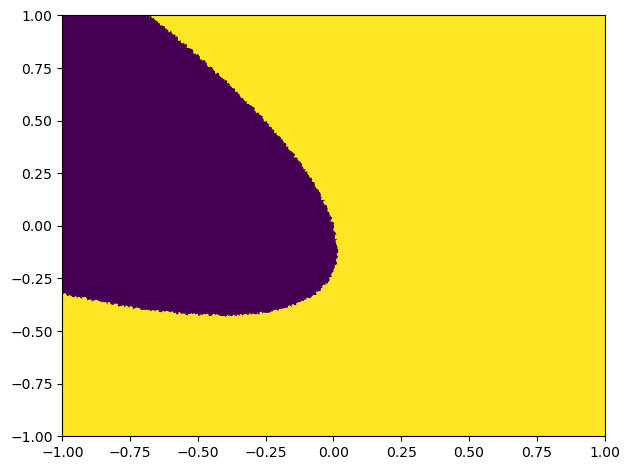

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.2400,  time_diff=0sec
m=       4,  train_acc=1.0000,  test_acc=0.5133,  time_diff=0sec
m=       8,  train_acc=0.9950,  test_acc=0.7867,  time_diff=0sec
m=      16,  train_acc=0.9775,  test_acc=0.9042,  time_diff=0sec
m=      32,  train_acc=0.9750,  test_acc=0.9379,  time_diff=0sec
m=      64,  train_acc=0.9738,  test_acc=0.9579,  time_diff=0sec
m=     128,  train_acc=0.9841,  test_acc=0.9708,  time_diff=0sec
m=     256,  train_acc=0.9881,  test_acc=0.9802,  time_diff=0sec
m=     512,  train_acc=0.9929,  test_acc=0.9887,  time_diff=0sec
m=    1024,  train_acc=0.9937,  test_acc=0.9925,  time_diff=0sec
m=    2048,  train_acc=0.9957,  test_acc=0.9949,  time_diff=0sec
m=    4096,  train_acc=0.9972,  test_acc=0.9969,  time_diff=1sec
m=    8192,  train_acc=0.9971,  test_acc=0.9974,  time_diff=2sec
m=   16384,  train_acc=0.9979,  test_acc=0.9979,  time_diff=3sec
m=   32768,  train_acc=0.

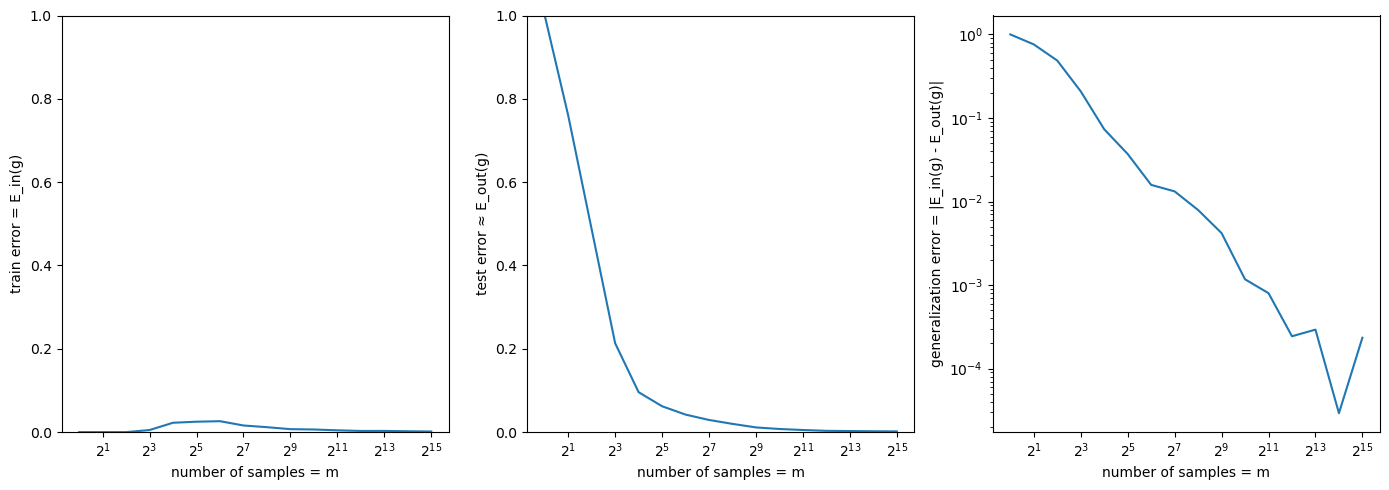

In [26]:
calculate_err_vs_m(
    d=2,
    sigma=0,
    f=f_polynomial(p=2),
    p=2,
)

generating dataset... done


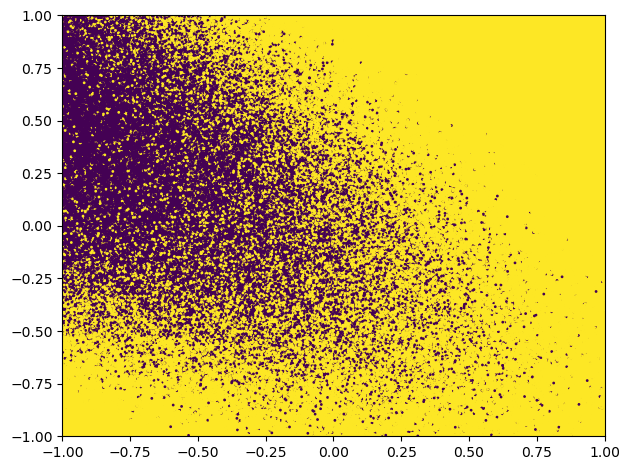

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.1667,  time_diff=0sec
m=       4,  train_acc=1.0000,  test_acc=0.4933,  time_diff=0sec
m=       8,  train_acc=0.9450,  test_acc=0.6317,  time_diff=0sec
m=      16,  train_acc=0.8950,  test_acc=0.7267,  time_diff=0sec
m=      32,  train_acc=0.8400,  test_acc=0.7712,  time_diff=0sec
m=      64,  train_acc=0.8313,  test_acc=0.8113,  time_diff=0sec
m=     128,  train_acc=0.8306,  test_acc=0.8028,  time_diff=0sec
m=     256,  train_acc=0.8287,  test_acc=0.8366,  time_diff=0sec
m=     512,  train_acc=0.8242,  test_acc=0.8247,  time_diff=0sec
m=    1024,  train_acc=0.8328,  test_acc=0.8386,  time_diff=0sec
m=    2048,  train_acc=0.8368,  test_acc=0.8456,  time_diff=0sec
m=    4096,  train_acc=0.8378,  test_acc=0.8462,  time_diff=1sec
m=    8192,  train_acc=0.8385,  test_acc=0.8487,  time_diff=2sec
m=   16384,  train_acc=0.8388,  test_acc=0.8497,  time_diff=4sec
m=   32768,  train_acc=0.

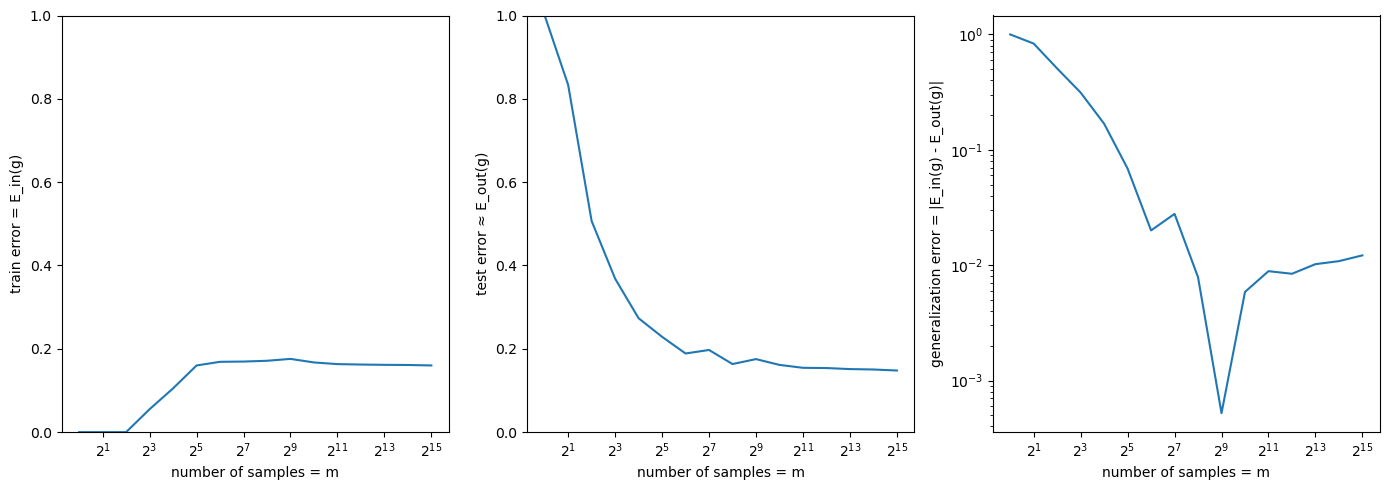

In [27]:
calculate_err_vs_m(
    d=2,
    sigma=0.2,
    f=f_polynomial(p=2),
    p=2,
)

### Definitions

We briefly introduce some common definitions that are not found in the textbook and we have not directly discussed in class.
These definitions will help us more succinctly state the following questions.
Another purpose of these definitions is to give you practice working with new definitions that you haven't seen explained before.
Data mining literature very frequently introduces new definitions that will be closely related,
but subtly different to definitions you've used before.

We call the "approximation error" of a hypothesis class to be the true error of the best possible model in the hypothesis class.
That is, the approximation error is
$$
E_{approx}(\mathcal{H}) = \text{argmin}_{h\in \mathcal H} E_{out}(h).
$$
Notice that the approximation error depends both on the hypothesis class chosen for learning, but also on the data distribution (since $E_{out}$ depends on the data distribution).
It does not, however, depend on the training data.

We call a hypothesis class "realizable" when the approximation error is 0.
That is, there exists some $h \in \mathcal H$ with $E_{out}(h) = 0$.
Notice that this definition is independent of the training data and the training algorithm.

### Question 3.1

*The three cells above plot the accuracy of the polynomial kernel in three situations:
when the model is not realizable because the degree of the polynomial is too small,
when the model is realizable,
and when the model is not realizable because of randomness in the labeling process.*

*Write 1-2 sentences about the differences you observe in each of these cases and how they relate to VC theory.*

Model not realizable (First Situation) with no noise due to insufficiently large p=1< degree of f=2: In this case we see $E_{in}$ increases as sample size rises and then levels off this is because with smaller samples it can randomly try to fit the data but as number of samples increases wee see that approximation error occurs because the true labelling function is of degree 2 but with only a hypotehsis class suporting linear function there simply is not enough flexibility to fit to the data. We see that generalization error reduces and then is super close to 0 (0.01 to 0.001 is basically zero and these fluctuations are due to randomness)due to a small vc dimension and approaches 0 as soon as sample size is large enough of being roughly $10 \cdot d_{vc}=10 \cdot 3=30 \sim 2^5=32$ practicallly as vc dim is ambient dimension + 1 for perceptron hyptesis class and generalization error is close to 0 after that (roughly 0.01 is basically 0). 

Model realizable (Second Situation) with no noise and to sufficiently large p=2= degree of f=2: When the model is realisaable since p=2 and degree of f=2 the true labelling function is inside our hypothesis class so with enough amples we find the true labelling function and $E_{in}$ goes to 0 as there is no approximation error. According to vc thoery the generalization error bounds grow linearly with dvc approximately so as we increase vc dimension since the vc bounds are still manageable and now that we inceased vc dimension we need larger number of samples for generation to error to go towards 0. We also see $E_{out}$ goes to 0 with enough samples as our model is just flexible enough to find a degree 2 decision boundary as when we do a do a feature transform to a higher dimension this data becomes linearly seperable and with no error we can distinguish between the two classification regions.

Model not realizable (Third Situation) with some noise but  sufficiently large p=2= degree of f=2: In this case with enough samples our $E_in$ rises at first starting from 0 and then levelling off. It stays at 0 for a little bit as the data is shattered for very small data sizes by our model. Even though the true labelling function is degree 2 and our model can fit to degree 2 decision boundaries the presence of noise makes perfect classification impossible so as sample size increase $E_{out}$ reduces and levels off at the true error of the data (the bayes error). According to vc theory we see the generalization error of case 2 and case 3 go to at roughly the same rate due to both of them having the same vc dimesnion. 

generating dataset... done


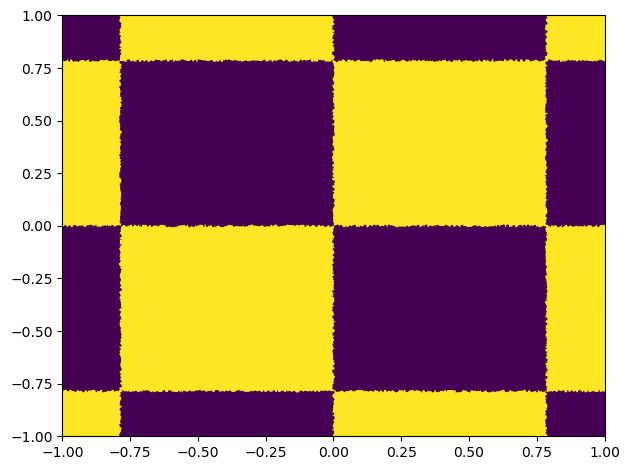

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.2200,  time_diff=0sec
m=       4,  train_acc=0.9900,  test_acc=0.5067,  time_diff=0sec
m=       8,  train_acc=1.0000,  test_acc=0.5000,  time_diff=0sec
m=      16,  train_acc=0.9550,  test_acc=0.5542,  time_diff=0sec
m=      32,  train_acc=0.8775,  test_acc=0.6429,  time_diff=1sec
m=      64,  train_acc=0.8506,  test_acc=0.7077,  time_diff=3sec
m=     128,  train_acc=0.9141,  test_acc=0.8108,  time_diff=7sec
m=     256,  train_acc=0.9277,  test_acc=0.8716,  time_diff=13sec
m=     512,  train_acc=0.9466,  test_acc=0.9202,  time_diff=24sec
m=    1024,  train_acc=0.9594,  test_acc=0.9467,  time_diff=34sec
m=    2048,  train_acc=0.9727,  test_acc=0.9664,  time_diff=45sec
m=    4096,  train_acc=0.9747,  test_acc=0.9713,  time_diff=65sec
m=    8192,  train_acc=0.9801,  test_acc=0.9799,  time_diff=106sec
m=   16384,  train_acc=0.9820,  test_acc=0.9826,  time_diff=188sec
m=   32768,  tra

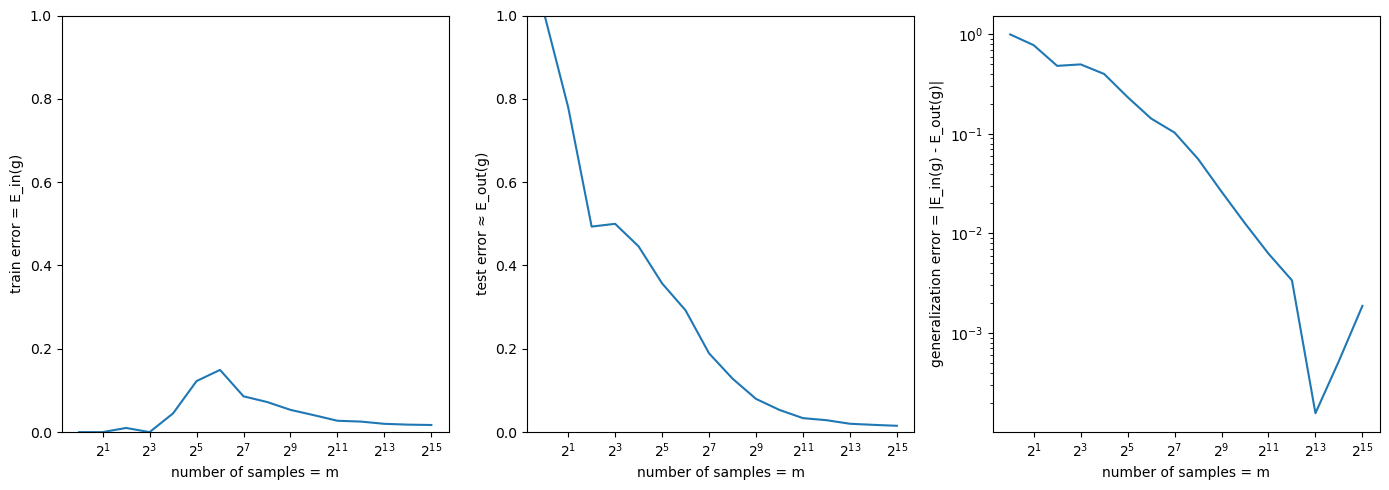

In [104]:
calculate_err_vs_m(
    d=2,
    sigma=0,
    f=f_checkers(),
    p=24,
)

### Question 3.2

*The dataset above is generated from the checkboard embedding instead of the polynomial embedding.
This implies that the polynomial embedding model is non-realizable for this problem.
Therefore, even when there is no randomness in the labeling process,
the model still cannot achieve 0 approximation error (i.e. $E_{out}(h)>0$ for all $h \in E_{out}(h)$.*

*Increasing the polynomial degree $p$ reduces the approximation error.
Try each value of $p$ starting at 1 until you reach an approximation error<1%.
What is that value of $p$?*

I wasnt able to reach an approximation error of <1% but at p=24 I had a test_acc=0.9848 which is a approx error of 1.52%>1% desired in the question. THis took me roughly 15 min to run so I decided to stop early. I was then told in office hours that the "%" was a typo but that it was ok to leave it like this and not redo calculations.

generating dataset... done


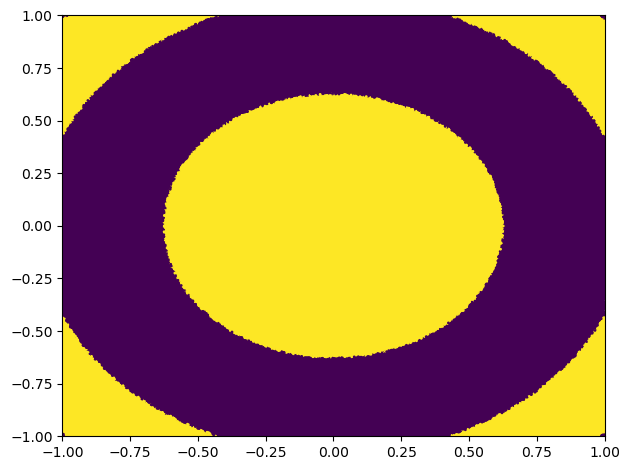

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.2467,  time_diff=0sec
m=       4,  train_acc=1.0000,  test_acc=0.5300,  time_diff=0sec
m=       8,  train_acc=0.9900,  test_acc=0.5867,  time_diff=0sec
m=      16,  train_acc=0.9675,  test_acc=0.7358,  time_diff=0sec
m=      32,  train_acc=0.9838,  test_acc=0.8133,  time_diff=2sec
m=      64,  train_acc=0.9725,  test_acc=0.8727,  time_diff=3sec
m=     128,  train_acc=0.9803,  test_acc=0.9400,  time_diff=7sec
m=     256,  train_acc=0.9839,  test_acc=0.9559,  time_diff=13sec
m=     512,  train_acc=0.9855,  test_acc=0.9701,  time_diff=24sec
m=    1024,  train_acc=0.9866,  test_acc=0.9794,  time_diff=34sec
m=    2048,  train_acc=0.9874,  test_acc=0.9851,  time_diff=44sec
m=    4096,  train_acc=0.9867,  test_acc=0.9879,  time_diff=67sec
m=    8192,  train_acc=0.9872,  test_acc=0.9902,  time_diff=106sec
m=   16384,  train_acc=0.9879,  test_acc=0.9917,  time_diff=191sec
m=   32768,  tra

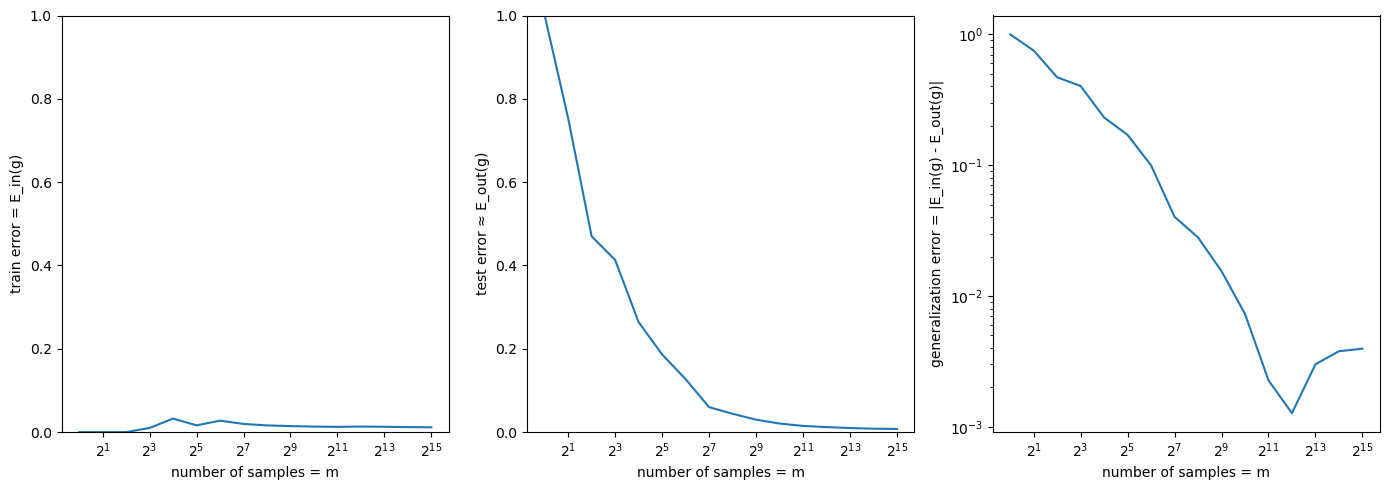

In [106]:
calculate_err_vs_m(
    d=2,
    sigma=0,
    f=f_circles(),
    p=24,
)

### Question 3.3

*The dataset above is also not realizable, but in a different way than in question 3.2.
Once again, your task is to find the exact $p$ value that will achieve an approximation error<0.01%.*

I went up to p=24 and this led to test_acc=0.9924 which means I had an approximation error of 0.76%>0.01% desired in the question. This took me 14 minutes to run so I decided to stop early. I was then told in office hours that the "%" was a typo but that it was ok to leave it like this and not redo calculations.

## Part 4: plotting the error as a function of the sample size $d$

In [30]:
def calculate_err_vs_d(m, sigma, f, p, max_dim_exponent, num_trials=default_num_trials):
    '''
    Plots the sample/true/generalization error for the halfspace with polynomial kernel model
    as a function of the number of sample training points.
    '''
    m_buffer = 3
    assert(2**max_dim_exponent<max_d)

    # these lists store the computer training and test errors
    test_errs = []
    train_errs = []
    
    # This is the list of all sample sizes we will train models on and generate train/test errors;
    # by adjusting the range(), you can adjust the x-axis in the plots below.
    ds = [ 2**i for i in range(0,max_dim_exponent) ]

    for d in ds:

        # In order to "smooth" the plots, we will repeat each experiment multiple times
        # as deterimed by the num_trials parameter.
        # These lists store the raw results from each trial.
        trials_test_accs = []
        trials_train_accs = []
        
        
        # loop over each trial
        seed_base = 10
        time_start = time.time()
        for seed in range(seed_base,seed_base+num_trials):
            
            # generate a training set of size m
            # from the same distribution as our test set;
            # notice that we must explicitly set a unique seed for each trial so that
            # each iteration is actually running on a different training set
            S_train = generate_dataset(m=m,d=d,f=f,sigma=sigma,seed=seed)
            S_test = generate_dataset(m=m,d=d,f=f,sigma=sigma,seed=seed-1)

            try:   
                # train a linear model;
                # notice that the training currently uses the LogisticRegression model;
                # all of the results will be essentially the same using the other linear models as well
                # since they all use the same hypothesis class
                X, Y = S_train
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                h_S = sklearn.linear_model.LogisticRegression(solver='liblinear',C=1e1)
                #h_S = sklearn.linear_model.Perceptron()
                #h_S = sklearn.linear_model.SGDClassifier()
                #h_S = sklearn.linear_model.PassiveAggressiveClassifier()
                #h_S = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
                #h_S = sklearn.svm.LinearSVC()
                h_S.fit(X, Y)

                # calculate the training accuracy
                train_acc = h_S.score(X,Y)

                # calculate the test accuracy
                X, Y = S_test
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                test_acc = h_S.score(X, Y)        

            # ValueError raised when there's not enough data to perform classification;
            # in this case, we get perfect training accuracy, but perfectly wrong test accuracy
            except ValueError:
                train_acc = 1
                test_acc = 0
                
            trials_test_accs.append(test_acc)
            trials_train_accs.append(train_acc)
        time_end = time.time()
        
        # compute the average of our trials
        train_acc = np.mean(trials_train_accs)
        test_acc = np.mean(trials_test_accs)
            
        # print a debugging statement for each iteration
        print('d=%8d,  train_acc=%0.4f,  test_acc=%0.4f,  time_diff=%dsec'%(
            d,
            train_acc,
            test_acc,
            time_end-time_start
        ))

        # convert the accuracies into errors and store them
        train_errs.append(1-train_acc)
        test_errs.append(1-test_acc)
    
    # plot the errors
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
    ax1.set_xscale('log',base=2)
    #ax1.set_yscale('log')
    ax1.set(
        xlabel='number of dimensions = d', 
        ylabel='train error = E_in(g)',
    )
    ax1.plot(ds,train_errs)
    
    ax2.set_xscale('log',base=2)
    #ax2.set_yscale('log')
    ax2.set(
        xlabel='number of dimensions = d', 
        ylabel='test error ≈ E_out(g)',
    )
    ax2.plot(ds,test_errs)
    
    ax3.set_xscale('log',base=2)
    ax3.set_yscale('log')
    ax3.set(
        xlabel='number of dimensions = d', 
        ylabel='generalization error = |E_in(g) - E_out(g)|',

    )
    ax3.plot(ds,np.abs(np.array(test_errs)-np.array(train_errs)))
    
    plt.tight_layout()
    plt.show()


d=       1,  train_acc=0.9611,  test_acc=0.9599,  time_diff=0sec
d=       2,  train_acc=0.9606,  test_acc=0.9586,  time_diff=0sec
d=       4,  train_acc=0.9743,  test_acc=0.9696,  time_diff=0sec
d=       8,  train_acc=0.9799,  test_acc=0.9729,  time_diff=0sec
d=      16,  train_acc=0.9846,  test_acc=0.9730,  time_diff=0sec
d=      32,  train_acc=0.9925,  test_acc=0.9646,  time_diff=0sec
d=      64,  train_acc=0.9993,  test_acc=0.9422,  time_diff=1sec
d=     128,  train_acc=1.0000,  test_acc=0.8993,  time_diff=2sec
d=     256,  train_acc=1.0000,  test_acc=0.8215,  time_diff=4sec
d=     512,  train_acc=1.0000,  test_acc=0.7395,  time_diff=7sec
d=    1024,  train_acc=1.0000,  test_acc=0.6807,  time_diff=15sec
d=    2048,  train_acc=1.0000,  test_acc=0.6330,  time_diff=29sec


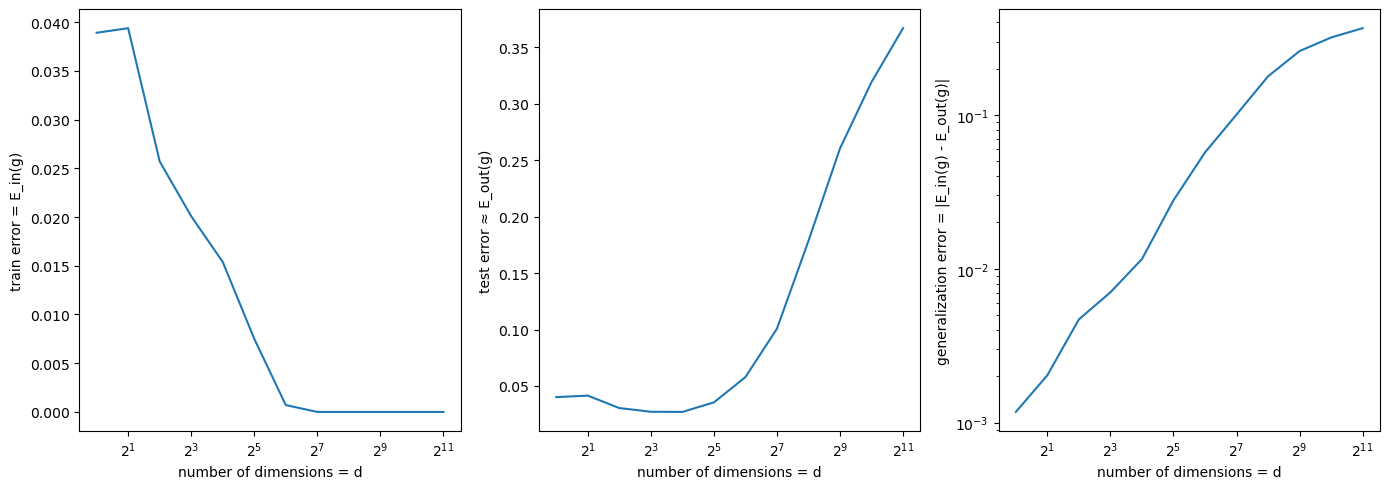

In [110]:
calculate_err_vs_d(
    m = 512,
    sigma = 0.1,
    f = f_polynomial(p=1),
    p = 1,
    max_dim_exponent=12,
)

### Question 4.1

*How does increasing the dimension $d$ of the input space affect the errors of the model?
How does VC theory predict this behavior?*


Increasing d results in $E_{in}$ reducing and generalisation error increcreasing. VC theory predicts that generalization error will increase as vc dimension increases as ambient space dimension increases meaning we need a larger number of samples to get the same generalization error but since number of samples is constant incresing vc dimensions imply causes generalisation error to rise. $E_{in}$ falls as in higher dimensional space due to higher vc dimesnion the data set simply get shattered by the model causing $E_{in}$ to go to 0 and remain at 0 once vc dimension is large enough to shatter the data set. As we see generalisation error increases with d and $E_{in}$ goes to 0 with increasing d we can see that $E_{out}$ rises. $E_{out}$ has this unbalanced parabolic shape as up to $2^4$ number of dimensions this increasing flexibility with increaseing vc dimension led to reduced out of sample error as we were able to fit the data without overfitting, after $2^5$ dimensions the model begins to overfit and we see that generalization error rises rapidly not compensating for the reduced $E_{in}$ leading to a worsening compromise between flexibility and generalization ability.

d=       1,  train_acc=0.9152,  test_acc=0.9142,  time_diff=0sec
d=       2,  train_acc=0.8173,  test_acc=0.8144,  time_diff=0sec
d=       4,  train_acc=0.8829,  test_acc=0.8770,  time_diff=0sec
d=       8,  train_acc=0.7648,  test_acc=0.7503,  time_diff=0sec
d=      16,  train_acc=0.7369,  test_acc=0.7127,  time_diff=1sec
d=      32,  train_acc=0.6860,  test_acc=0.6297,  time_diff=6sec
d=      64,  train_acc=0.6760,  test_acc=0.5619,  time_diff=20sec
d=     128,  train_acc=0.7350,  test_acc=0.5224,  time_diff=125sec


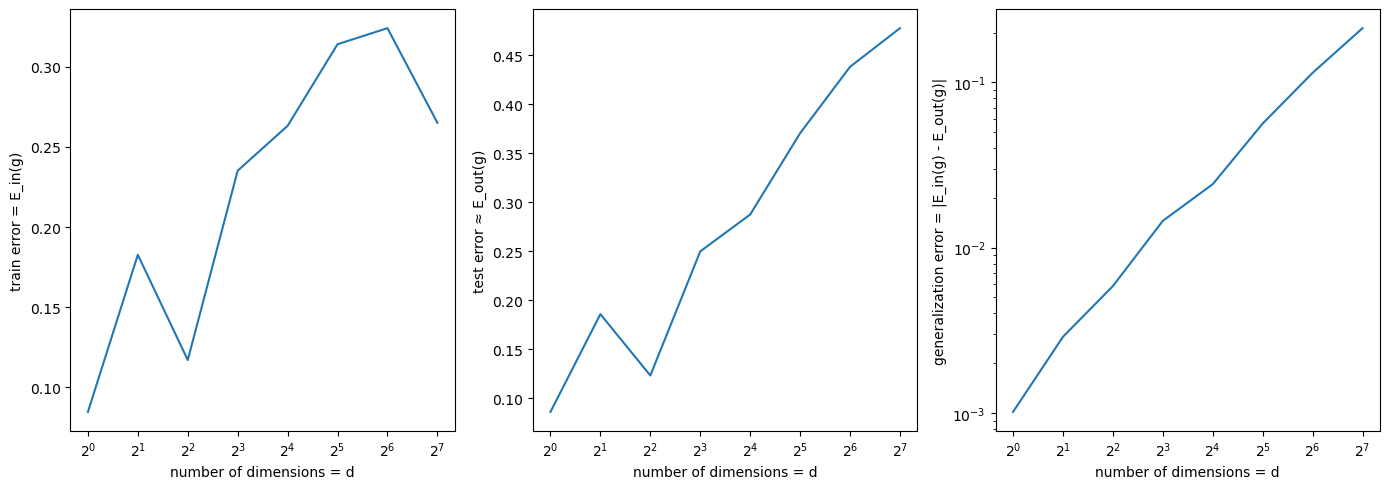

In [32]:
calculate_err_vs_d(
    m = 512,
    sigma = 0.1,
    f = f_polynomial(p=2),
    p = 1,
    max_dim_exponent=8
)

### Question 4.2

*The plot above is generated using almost the same formula as the plot for 4.1.
The exception is that the $f$ function is more complicated (polynomial degree 2 instead of degree 1).
What effect does this have on the the errors?*

The true labelling function is of degree 2 while our hypthesis class is only degree 1 expansion so we cannot possibly fit to our data using our hypthesis space so our approximation error will be >0. It appears as number of dimensions increases $E_{in}$ increases. So increasing d doesn't let us fit to our data and our $E_{in}$ is close to $E_{out}$.As we do increase number of dimenison we have that our vc dimension does increase resulting in a greater generalization error albeit much slower than the previous cases. The generalization error seems to grow linearly with number of dimesions. There are aberaations in data with peaks and valleys in $E_{out}$ and $E_{in}$ due to sigma=0.1 implying the presence of random noise. This more complicated f means we cannot shatter the data set and that we are unable to completely classify the data perfectly leading to a non zero approximation error as the true labelling function is not in out hypothesis class alongside with the presence of noise.

## Part 5: plotting the error as a function of the polynomial degree

### Question 5.1

The goal of this question is to demonstrate that large degree polynomial embeddings overfit.
This will require writing a new function `calculate_err_vs_p` that is based off of `calculate_err_vs_m` and `calculate_err_vs_d`.
Plot the train, test, and generalization errors as a function of `p`.
You should find that "small" and "large" values both generate large test errors,
and "medium" values of `p` generate small test errors.

I recommend using values of `m = 32`, `d = 8`, `sigma = 0.0`, and `f = f_polynomial(p=2)`.
Adjust the value of the `p` variable starting at `1` and going large enough to see the pattern of overfitting.

In [117]:
def calculate_err_vs_p(m, sigma, f, d, max_p, num_trials=default_num_trials):
    '''
    Plots the sample/true/generalization error for the halfspace with polynomial kernel model
    as a function of polynomial feature expansion degree
    '''
    m_buffer = 3

    # these lists store the computed training and test errors
    test_errs = []
    train_errs = []
    
    # This is the list of all polynomial degrees we will train models on
    ps = [i for i in range(1, max_p)]

    for p in ps:
        # In order to "smooth" the plots, we repeat each experiment multiple times
        # as determined by the num_trials parameter.
        # These lists store the raw results from each trial.
        trials_test_accs = []
        trials_train_accs = []
        
        # loop over each trial
        seed_base = 10
        time_start = time.time()
        for seed in range(seed_base, seed_base + num_trials):
            
            # generate a training set of size m
            S_train = generate_dataset(m=m, d=d, f=f, sigma=sigma, seed=seed)
            S_test = generate_dataset(m=m, d=d, f=f, sigma=sigma, seed=seed-1)

            try:   
                # train a linear model
                X, Y = S_train
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x, p), 1, X)
                h_S = sklearn.linear_model.LogisticRegression(solver='liblinear', C=1e1)
                h_S.fit(X, Y)

                # calculate the training accuracy
                train_acc = h_S.score(X, Y)

                # calculate the test accuracy
                X, Y = S_test
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x, p), 1, X)
                test_acc = h_S.score(X, Y)        

            # ValueError raised when there's not enough data to perform classification;
            except ValueError:
                train_acc = 1
                test_acc = 0
                
            trials_test_accs.append(test_acc)
            trials_train_accs.append(train_acc)
        time_end = time.time()
        
        # compute the average of our trials
        train_acc = np.mean(trials_train_accs)
        test_acc = np.mean(trials_test_accs)
            
        # print a debugging statement for each iteration
        print(f'p={p:8d},  train_acc={train_acc:.4f},  test_acc={test_acc:.4f},  time_diff={time_end-time_start}sec')

        # convert the accuracies into errors and store them
        train_errs.append(1 - train_acc)
        test_errs.append(1 - test_acc)
    
    # plot the errors
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
    
    # Use ps for x-axis
    ax1.set_xscale('log', base=2)
    ax1.set(
        xlabel='polynomial feature expansion degree  = p', 
        ylabel='train error = E_in(g)',
    )
    ax1.plot(ps, train_errs)
    
    ax2.set_xscale('log', base=2)
    ax2.set(
        xlabel='polynomial feature expansion degree  = p', 
        ylabel='test error ≈ E_out(g)',
    )
    ax2.plot(ps, test_errs)
    
    ax3.set_xscale('log', base=2)
    ax3.set_yscale('log')
    ax3.set(
        xlabel='polynomial feature expansion degree  = p', 
        ylabel='generalization error = |E_in(g) - E_out(g)|',
    )
    ax3.plot(ps, np.abs(np.array(test_errs) - np.array(train_errs)))
    
    plt.tight_layout()
    plt.show()


p=       1,  train_acc=0.8538,  test_acc=0.6887,  time_diff=0.05782008171081543sec
p=       2,  train_acc=1.0000,  test_acc=0.7412,  time_diff=0.05892300605773926sec
p=       3,  train_acc=1.0000,  test_acc=0.7438,  time_diff=0.14033722877502441sec
p=       4,  train_acc=1.0000,  test_acc=0.7188,  time_diff=0.4711618423461914sec
p=       5,  train_acc=1.0000,  test_acc=0.7188,  time_diff=1.4099810123443604sec
p=       6,  train_acc=1.0000,  test_acc=0.7150,  time_diff=4.615602970123291sec
p=       7,  train_acc=1.0000,  test_acc=0.7013,  time_diff=11.864268064498901sec
p=       8,  train_acc=1.0000,  test_acc=0.7013,  time_diff=28.108551263809204sec
p=       9,  train_acc=1.0000,  test_acc=0.6987,  time_diff=56.22760605812073sec


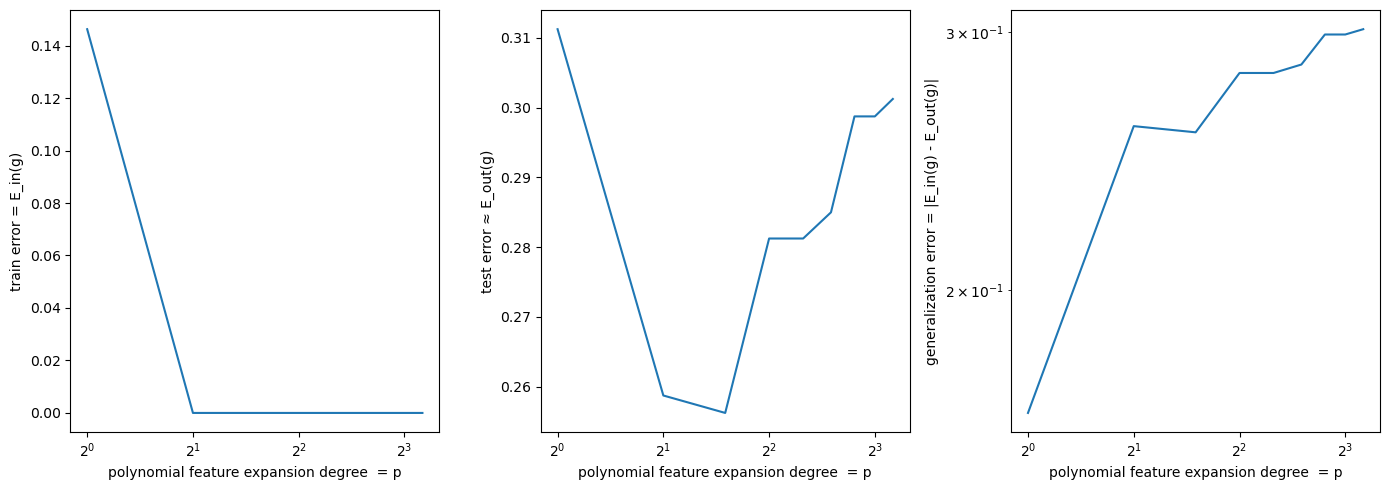

In [118]:
calculate_err_vs_p(
    m=32,
    d=8,
    sigma=0,
    f=f_polynomial(2),
    max_p=10
)

The trend in $E_{in}$ is that it reduces as p increases and levels off at 0. This is as p increases we have a lot more flexibility so we are able to fit to our training data better. After p=2^1 and above our hypthesis class contains the true labelling function so $E_{in}=0$ as there is no noise so perfect classification is possible for $p \geq 2^1$. For even larger p's we can start over fitting than that eventually we our able to shatter our training data set leading to $E_{in}=0$. The generalization error increases as p increases as our sample size remains the same so we our generalization error gets worse. To maintian same generalization error as vc dimension rises we need sample size to increase but since sample size is constant this leads to generalization rises. We see in $E_{out}$ a trend that it reduces as p rises going to a mining and then starts to increase as p rises. In the decreasing part of $E_{out}$ we see as p rises we get the neccesary flexibility to fit to our data better reducing the approximation error. For higher p expansion than that $E_{out}$ starts to increase as there is too much flexibility and we start to over fit to our input training data.